# Call Reports Analysis

##### Housekeeping and loading data

In [1]:
# Load packages
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'
path_output = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/output'

# set colorblind theme for plots:
sns.set_theme(context='notebook', style="ticks", palette='colorblind')
sns.set_color_codes(palette='colorblind')

# Set path to be the directory:
os.chdir(path)

In [3]:
# Load monetary policy shock data:
mp_shocks = pd.read_csv('brw-shock-series.csv')

# Drop column that has 'Unnamed' in it:
mp_shocks = mp_shocks.loc[:, ~mp_shocks.columns.str.contains('^Unnamed')]

# keep only the first 4 columns:
mp_shocks = mp_shocks.iloc[:, 0:4]

# rename columns:
mp_shocks.columns = mp_shocks.columns.str.replace(' (updated)', '')
mp_shocks.loc[:, 'month'] = mp_shocks['month'].str.replace('m', '-')
mp_shocks = mp_shocks[['month', 'BRW_monthly']]

# drop the 'NaT' row:
mp_shocks = mp_shocks.dropna()
mp_shocks['month'] = pd.to_datetime(mp_shocks['month'], format='%Y-%m')
# compute the quarterly average of the monthly shocks:
mp_shocks['quarter'] = mp_shocks['month'].dt.to_period('Q')
mp_shocks['BRW_quarterly'] = mp_shocks.groupby('quarter')['BRW_monthly'].transform('sum')

# keep only one observation for 'month' and 'BRW_quarterly' for each quarter:
mp_shocks = mp_shocks.drop_duplicates(subset='quarter', keep='first')
mp_shocks['Date'] = mp_shocks['month'] - pd.DateOffset(days = 1)

mp_shocks = mp_shocks[['Date', 'BRW_quarterly']]
mp_shocks.rename(columns={'BRW_quarterly': 'MP Shocks'}, inplace=True)

mp_shocks.loc[:,'Positive FF Shock'] = 0
mp_shocks.loc[mp_shocks['MP Shocks'] > 0, 'Positive FF Shock'] = 1

In [26]:
# Load the Excess Bond Premium data:
ebp = pd.read_csv('ebp_csv.csv')

In [27]:
ebp

,date,gz_spread,ebp,est_prob
0,1973-01-01,1.101827,0.015182,0.219606
1,1973-02-01,1.045423,-0.003915,0.213002
2,1973-03-01,0.995689,-0.094057,0.183436
3,1973-04-01,0.955333,-0.153461,0.165425
4,1973-05-01,1.007393,-0.058243,0.194863
...,...,...,...,...
619,2024-08-01,1.090099,-0.061134,0.193925
620,2024-09-01,1.046020,-0.118405,0.175911
621,2024-10-01,0.980231,-0.363098,0.111304
622,2024-11-01,0.943925,-0.244725,0.140065


In [4]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'CPIAUCSL_NBD19840101': 'CPI',
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'].astype(float)
aggregates['CPI'] = aggregates['CPI'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['CPI'] * 100
aggregates = aggregates.dropna()

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

# create 'Inflation' as the growth rate of the CPI:
aggregates['Inflation'] = aggregates['CPI'].pct_change(fill_method=None)

# create a variable named 'High Inflation' as 1 if the inflation is above the average, and 0 otherwise:
aggregates['High Inflation'] = 0
aggregates.loc[aggregates['Inflation'] > aggregates['Inflation'].mean(), 'High Inflation'] = 1

# create a variable named 'FF Hike' as 1 if the FF rate increased, and 0 otherwise:
aggregates['FF Hike'] = 0
aggregates.loc[aggregates['FEDFUNDS'] > aggregates['FEDFUNDS'].shift(1), 'FF Hike'] = 1

param = 1600

# De-trend the variables using an HP filter:
aggregates['De-trended Real GDP'] = sm.tsa.filters.hpfilter(np.log(aggregates['Real GDP']), lamb=param)[0]

# create a variable named 'Boom' that is 1, if the De-trended Real GDP is above 0, and 0 otherwise:
aggregates['Recession'] = 0
aggregates.loc[aggregates['De-trended Real GDP'] < 0, 'Recession'] = 1

In [5]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_1992\914245168.py:2: DtypeWarning: Columns (31,72,313,350,361,683,918,921,924,925,926,927,928,929,934,935,936,941,944,947,948,949,950,951,952,957,958,959,989,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1242,1243) have mixed t

In [6]:
# drop all columns in main that start with 'Unnamed':
main = main.loc[:, ~main.columns.str.contains('^Unnamed')]

main['Year'] = main['Date'].dt.year

In [7]:
# merge the data:
main  = pd.merge(main, aggregates, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])
main = pd.merge(main, mp_shocks, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])

In [8]:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

In [9]:
# load data on mergers and acquisitions:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

# rename the columns:
transformations = transformations.rename(columns={'#ID_RSSD_PREDECESSOR': 'Predecessor ID', 
                                                  'ID_RSSD_SUCCESSOR': 'Successor ID',
                                                 'DT_TRANS': 'Transaction Date',
                                                 'TRNSFM_CD': 'Transaction Code',})

# convert the 'transaction_date' to datetime format:
transformations['Transaction Date'] = pd.to_datetime(transformations['Transaction Date'], format='%Y%m%d')
transformations = transformations[['Predecessor ID', 'Successor ID', 'Transaction Date', 'Transaction Code']]


##### Basic Definitions

###### Balance sheet definitions

In [10]:
# create 'Total Assets' variable. If the bank fills the FFIEC41 (only RCON series available). Large banks may also have the 
# RCFD series available. If both are NaN, fill with NaN. If both are available, use the RCON series. If only RCFD is available,
# use RCFD. 
main['Total Assets'] = main['RCON2170'].combine_first(main['RCFD2170'])

print(main['RCON2170'].describe())
print(main['RCFD2170'].describe())
print(main['Total Assets'].describe())

main['Total Assets'] = main['Total Assets'].mask(main['Total Assets'] == 0, np.nan)

count    6.261330e+05
mean     9.698809e+05
std      1.251680e+07
min      0.000000e+00
25%      6.915500e+04
50%      1.506950e+05
75%      3.632950e+05
max      1.445545e+09
Name: RCON2170, dtype: float64
count    9.425000e+03
mean     1.016951e+08
std      3.093355e+08
min      4.264000e+03
25%      1.437040e+06
50%      1.221104e+07
75%      6.568676e+07
max      3.503360e+09
Name: RCFD2170, dtype: float64
count    6.307380e+05
mean     2.068706e+06
std      3.861057e+07
min      0.000000e+00
25%      6.962000e+04
50%      1.522710e+05
75%      3.717335e+05
max      3.503360e+09
Name: Total Assets, dtype: float64


In [11]:
main['Total Loans'] = main['RCON2122'].combine_first(main['RCFD2122'])

print(main['RCON2122'].describe())
print(main['RCFD2122'].describe())
print(main['Total Loans'].describe())

main['Total Loans'] = main['Total Loans'].mask(main['Total Loans'] == 0, np.nan)
print(main['Total Loans'].describe())

count    6.307380e+05
mean     1.093833e+06
std      1.610038e+07
min      0.000000e+00
25%      3.957900e+04
50%      9.519400e+04
75%      2.430490e+05
max      1.210463e+09
Name: RCON2122, dtype: float64
count    9.425000e+03
mean     5.062150e+07
std      1.382338e+08
min      0.000000e+00
25%      7.329730e+05
50%      7.253951e+06
75%      3.625600e+07
max      1.331054e+09
Name: RCFD2122, dtype: float64
count    6.307380e+05
mean     1.093833e+06
std      1.610038e+07
min      0.000000e+00
25%      3.957900e+04
50%      9.519400e+04
75%      2.430490e+05
max      1.210463e+09
Name: Total Loans, dtype: float64
count    6.205110e+05
mean     1.111861e+06
std      1.623190e+07
min      1.000000e+00
25%      4.160400e+04
50%      9.780600e+04
75%      2.478150e+05
max      1.210463e+09
Name: Total Loans, dtype: float64


C:\Users\angel\AppData\Local\Temp\ipykernel_1992\2193418771.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  main['Total Loans'] = main['RCON2122'].combine_first(main['RCFD2122'])


In [12]:
# create 'Total Deposits'
main.rename(columns = {'RCON2200':'Total Deposits'}, inplace = True)
main['Total Deposits'] = main['Total Deposits'].mask(main['Total Deposits'] == 0, np.nan)
print(main['Total Deposits'].describe())

count    6.242610e+05
mean     1.424842e+06
std      2.496490e+07
min      1.000000e+00
25%      5.904900e+04
50%      1.283820e+05
75%      3.082980e+05
max      2.201118e+09
Name: Total Deposits, dtype: float64


In [13]:
# create 'Cash' summing RCON0020 and RCON0080:
main['Cash'] = main['RCON0010'].combine_first(main['RCON0071']+main['RCON0081'])
main['Cash'] = main['Cash'].mask(main['Cash'] <= 0, np.nan)
print(main['Cash'].describe())

count    6.299250e+05
mean     1.673560e+05
std      4.188713e+06
min      1.000000e+00
25%      3.340000e+03
50%      8.333000e+03
75%      2.219700e+04
max      5.436850e+08
Name: Cash, dtype: float64


In [14]:
# create 'Securities AC' summing RCON1754 and RCON1772. If both are NaN, fill with NaN. If only one is available, use that one. If both 
# are available sum them:
main['Securities AC'] = main[['RCON1754', 'RCON1772']].apply(
    lambda row: np.nan if pd.isna(row['RCON1754']) and pd.isna(row['RCON1772']) else (row.fillna(0).sum()),
    axis=1
)
main['Securities AC'] = main['Securities AC'].mask(main['Securities AC'] <= 0, np.nan)
print(main['Securities AC'].describe())

count    5.747550e+05
mean     1.759930e+05
std      4.215933e+06
min      1.000000e+00
25%      1.025950e+04
50%      2.694200e+04
75%      7.029350e+04
max      6.830540e+08
Name: Securities AC, dtype: float64


In [15]:
# compute the 'Deposit Share' of each bank, per 'Date':
main.loc[:,'Deposit Share'] = main['Total Deposits']/main.groupby('Date')['Total Deposits'].transform('sum')
print(main['Deposit Share'].describe())

count    6.242610e+05
mean     1.489761e-04
std      2.201751e-03
min      1.140498e-10
25%      7.917410e-06
50%      1.661926e-05
75%      3.802868e-05
max      1.256486e-01
Name: Deposit Share, dtype: float64


###### Income Definitions

In [16]:
# compute the variable above avoiding the SettingWithCopyWarning:
main.loc[:, 'Deposit Expenditure'] = (main['RIAD4073'].fillna(0) - main['RIAD4200'].fillna(0) - main['RIAD4185'].fillna(0) - 
                                      main['RIAD4180'].fillna(0) - main['RIAD4172'].fillna(0))

In [17]:
main.loc[:, 'Actual Deposit Exp'] = main.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(main['Deposit Expenditure'])
main.loc[:, 'Actual Deposit Exp'] = main['Actual Deposit Exp'].mask(main['Actual Deposit Exp'] <= 0, np.nan)
main['Actual Deposit Exp'].describe()

count    6.208830e+05
mean     3.142196e+03
std      5.409451e+04
min      1.000000e+00
25%      1.450000e+02
50%      3.590000e+02
75%      9.190000e+02
max      9.013000e+06
Name: Actual Deposit Exp, dtype: float64

In [18]:
# Compute deposit rates:
main.loc[:,'Deposit Rate'] = main['Actual Deposit Exp'] / main['Total Deposits']
print(main['Deposit Rate'].describe())
main.loc[:,'Deposit Spread'] = -main['Deposit Rate'] + main['FEDFUNDS']
print(main['Deposit Spread'].describe())

count    6.207750e+05
mean     3.810616e-03
std      4.383616e-02
min      1.480123e-07
25%      1.331875e-03
50%      2.956697e-03
75%      5.439870e-03
max      3.327273e+01
Name: Deposit Rate, dtype: float64
count    620775.000000
mean          0.012682
std           0.046624
min         -33.271794
25%          -0.000169
50%           0.007256
75%           0.021466
max           0.053298
Name: Deposit Spread, dtype: float64


In [19]:
balanced_panel = 0

if balanced_panel == 1:

    # Step 1: Count the total number of unique dates in the dataset
    total_dates = main['Date'].nunique()
    print('Number of dates:', total_dates)

    # Step 2: Count the number of unique dates each bank shows up
    bank_date_counts = main.groupby('IDRSSD')['Date'].nunique()
    print('Banks that show up in all dates:', sum(bank_date_counts==total_dates))

    # Step 3: Identify banks that are present in all dates with positive 'Total Deposit':
    banks = bank_date_counts[bank_date_counts == total_dates].index
    main = main[main['IDRSSD'].isin(banks)]


In [20]:
# Create an extra column in df3 with the avg. deposit rate per Date:
main.loc[:,'Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
main.loc[:,'Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
main.loc[:,'R_hat'] = (main['Deposit Rate'] - main['Avg. Deposit Rate']) / main['Std. Deposit Rate']
main['R_hat'].describe()

count    6.207750e+05
mean    -1.684860e-17
std      9.999259e-01
min     -4.562269e+00
25%     -3.530443e-01
50%     -2.620928e-02
75%      2.553828e-01
max      9.261549e+01
Name: R_hat, dtype: float64

In [21]:
def compute_growth(df, transformations, window=1):
    """
    Compute the log difference of deposits while accounting for mergers, acquisitions, and failures.

    Args:
    - df (pd.DataFrame): Dataframe containing bank-level balance sheet data.
    - transformations (pd.DataFrame): Dataframe containing information about transformations.
    - window (int): Number of quarters before and after a transaction to set as NaN for growth rate.

    Returns:
    - pd.DataFrame: The updated 'df' with a 'deposit_growth' column.
    """
    # Sort the dataframe by bank ID and date to ensure proper lag calculation
    df = df.sort_values(by=['IDRSSD', 'Date'])
    df['Real Deposits'] = df['Total Deposits'] / df['CPI'] * 100
    df['Real Loans'] = df['Total Loans'] / df['CPI'] * 100


    # Calculate log difference (log growth rate) of deposits
    df['Deposit_Growth'] = df.groupby('IDRSSD')['Real Deposits'].transform(lambda x: np.log(x).diff())
    df['Loan_Growth'] = df.groupby('IDRSSD')['Real Loans'].transform(lambda x: np.log(x).diff())
    
    # Create a mask to identify rows to be set to NaN
    for _, row in transformations.iterrows():
        predecessor_id = row['Predecessor ID']
        successor_id = row['Successor ID']
        transaction_date = row['Transaction Date']
        
        # Identify date range around the transaction
        start_date = transaction_date - pd.DateOffset(months=3 * window)
        end_date = transaction_date + pd.DateOffset(months=3 * window)
        
        # Apply NaN to the specified window for predecessor and successor banks
        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Deposit_Growth'
        ] = np.nan

        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Loan_Growth'
        ] = np.nan
    
    return df


# Define function to compute binned averages using qcut
def binned_scatter(x, y, q, label):
    # Create quantile bins using qcut
    x_binned, bin_edges = pd.qcut(x, q=q, retbins=True, duplicates='drop')
    bin_centers = [x[(x_binned == interval)].mean() for interval in x_binned.unique()]
    binned_means = [y[x_binned == interval].mean() for interval in x_binned.unique()]
    
    # Plot the binned means
    plt.scatter(bin_centers, binned_means, label=label, alpha=0.7, s=50)

    # Add a 45-degree line for reference:
    #plt.plot([min(x), max(x)], [min(x), max(x)], linestyle='--', color='black', alpha=0.5)


## Deposits

In [22]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',             # Dates and IDS 
            'Total Deposits', 'Deposit Share', 'Total Assets',          # Bank specific quantity variables
            'Total Loans',
            'Deposit Rate', 'Deposit Spread',                           # Bank specific rate variable
            'Cash', 'Securities AC',                                    # Bank specific asset variables
            'FEDFUNDS', 'High Inflation', 'FF Hike', 'Recession',
            'CPI', 'Positive FF Shock'                                  # Macro variables
            ]]

In [23]:
# compute the correlation between FF Hike and Positive FF Shock:
df[['FF Hike', 'Positive FF Shock']].corr()

,FF Hike,Positive FF Shock
FF Hike,1.000000,0.110165
Positive FF Shock,0.110165,1.000000


In [24]:
df = compute_growth(df, transformations, window=1)

KeyboardInterrupt: 

In [25]:
print(df['Loan_Growth'].describe())
print(df['Loan_Growth'].quantile([0.01, 0.99]))

count    593175.000000
mean          0.013968
std           0.124984
min          -9.876718
25%          -0.017473
50%           0.006592
75%           0.033002
max          10.035145
Name: Loan_Growth, dtype: float64
0.01   -0.134810
0.99    0.262781
Name: Loan_Growth, dtype: float64


In [26]:
print(df['Deposit_Growth'].describe())
print(df['Deposit_Growth'].quantile([0.01, 0.99]))

count    596813.000000
mean          0.013327
std           0.124075
min         -11.549798
25%          -0.019729
50%           0.004571
75%           0.033348
max          10.453121
Name: Deposit_Growth, dtype: float64
0.01   -0.129371
0.99    0.268824
Name: Deposit_Growth, dtype: float64


In [27]:
# mask the outliers (top and bottom 0.1%) of the distribution of 'Deposit Growth':
df['Deposit_Growth'] = df['Deposit_Growth'].mask((df['Deposit_Growth'] < df['Deposit_Growth'].quantile(0.01)) | 
                                                 (df['Deposit_Growth'] > df['Deposit_Growth'].quantile(0.99)), np.nan)

df['Loan_Growth'] = df['Loan_Growth'].mask((df['Loan_Growth'] < df['Loan_Growth'].quantile(0.01)) | 
                                                 (df['Loan_Growth'] > df['Loan_Growth'].quantile(0.99)), np.nan)


In [28]:
df['Securities Growth'] = df.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
print(df['Securities Growth'].describe())
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
df['Securities Growth'] = df['Securities Growth'].mask((df['Securities Growth'] < df['Securities Growth'].quantile(0.01)) | (df['Securities Growth'] > df['Securities Growth'].quantile(0.99)))
print(df['Securities Growth'].describe())

count    563315.000000
mean          1.016784
std         473.515140
min          -0.999945
25%          -0.046749
50%          -0.002478
75%           0.062449
max      353730.333333
Name: Securities Growth, dtype: float64
count    552047.000000
mean          0.024549
std           0.161587
min          -0.428653
25%          -0.045536
50%          -0.002478
75%           0.060176
max           1.238243
Name: Securities Growth, dtype: float64


In [29]:
df['Real Cash'] = df['Cash'] / df['CPI'] * 100
df['Cash Growth'] = df.groupby('IDRSSD')['Real Cash'].pct_change(fill_method=None)
print(df['Cash Growth'].describe())
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
df['Cash Growth'] = df['Cash Growth'].mask((df['Cash Growth'] < df['Cash Growth'].quantile(0.01)) | (df['Cash Growth'] > df['Cash Growth'].quantile(0.99)))
print(df['Cash Growth'].describe())

count    619000.000000
mean          0.359343
std          55.967465
min          -0.999954
25%          -0.174054
50%           0.007600
75%           0.239236
max       29633.627256
Name: Cash Growth, dtype: float64
count    606620.000000
mean          0.094076
std           0.459386
min          -0.696791
25%          -0.169392
50%           0.007600
75%           0.232258
max           2.896913
Name: Cash Growth, dtype: float64


In [68]:
def cross_sectional_plots(  df,                     # Dataframe with bank-level data 
                            criteria,               # Criteria to define the interest rate shock
                            num_quantiles=100):     # Number of quantiles for the binned scatter plot

    # Define the interest rate criteria:
    # 1. 'ff_hike': FF Hike is a simple increase in the FFR.
    # 2. 'mp_shock': MP Shock is a positive shock to the FFR.
    if criteria == 'ff_hike':
        # Filter conditions for Expansion and Contraction
        expansion_condition = (df['Recession'] == 0) & (df['FF Hike'] == 1) & (df['High Inflation'] == 1)
        contraction_condition = (df['Recession'] == 1) & (df['FF Hike'] == 1) & (df['High Inflation'] == 1)

    elif criteria == 'mp_shock':
        # Filter conditions for Expansion and Contraction
        expansion_condition = (df['Recession'] == 0) & (df['Positive FF Shock'] == 1) & (df['High Inflation'] == 1)
        contraction_condition = (df['Recession'] == 1) & (df['Positive FF Shock'] == 1) & (df['High Inflation'] == 1)

    else:
        print('Criteria not found')
        return None
    
    # --------------------------------- Histograms --------------------------------- #

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    lin = np.linspace(-0.25, 0.25, 150)
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Loan_Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Loan_Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Loan_Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Loan_Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Loan Growth (High Inflation, FF Hike)')
    plt.xlabel('Loan Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Loan_Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Loan_Growth'].std(), 4)))
    plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Loan_Growth'].mean(), 4)))
    plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Loan_Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.13, 0.22)
    plt.show()


    lin = np.linspace(-0.25, 0.25, 150)
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Deposit_Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Deposit_Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Deposit_Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Deposit_Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Deposits Growth (High Inflation, FF Hike)')
    plt.xlabel('Deposits Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Deposit_Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Deposit_Growth'].std(), 4)))
    plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Deposit_Growth'].mean(), 4)))
    plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Deposit_Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.13, 0.22)
    plt.show()

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Securities Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Securities Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Securities Growth (High Inflation, FF Hike)')
    plt.xlabel('Securities Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7.5, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Securities Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Securities Growth'].std(), 4)))
    plt.text(0.1, 5.5, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Securities Growth'].mean(), 4)))
    plt.text(0.1, 4.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Securities Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.25, 0.25)
    plt.show()

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    plt.figure(figsize=(12, 6))
    lin = np.linspace(df['Cash Growth'].min(), 2, 150)
    sns.histplot(df[expansion_condition]['Cash Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Cash Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Cash Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Cash Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Cash Growth (High Inflation, FF Hike)')
    plt.xlabel('Cash Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(1, 1.4, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Cash Growth'].mean(), 4)))
    plt.text(1, 1.3, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Cash Growth'].std(), 4)))
    plt.text(1, 1.2, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Cash Growth'].mean(), 4)))
    plt.text(1, 1.1, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Cash Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()


    # --------------------------------- Scatter Plots --------------------------------- #
    #-------------------------------------------------------------------------------------------------#

    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Loan_Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Loan_Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Loan Growth vs. Securities Growth (Quantile Bins)')
    plt.ylabel('Loan Growth')
    plt.xlabel('Securities Growth')
    plt.ylim(-0.05, 0.12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Loan_Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Loan_Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Loan Growth (Quantile Bins)')
    plt.ylabel('Loan Growth')
    plt.xlabel('Deposits Growth')
    plt.ylim(-0.01, 0.05)
    plt.xlim(-0.1, 0.2)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Cash Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Cash Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Cash Growth (Quantile Bins)')
    plt.ylabel('Cash Growth')
    plt.xlabel('Deposits Growth')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Securities Growth (Quantile Bins)')
    plt.ylabel('Securities Growth')
    plt.xlabel('Deposits Growth')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

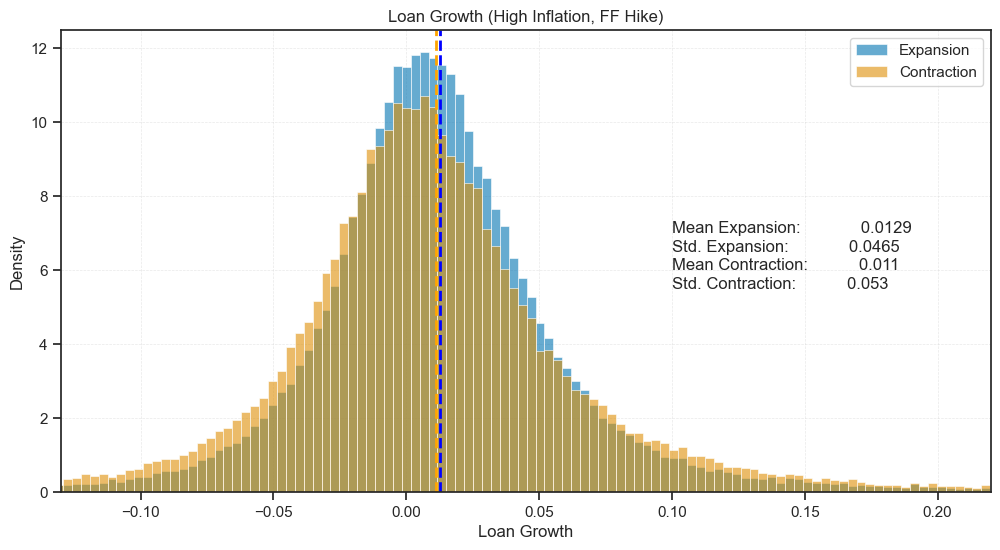

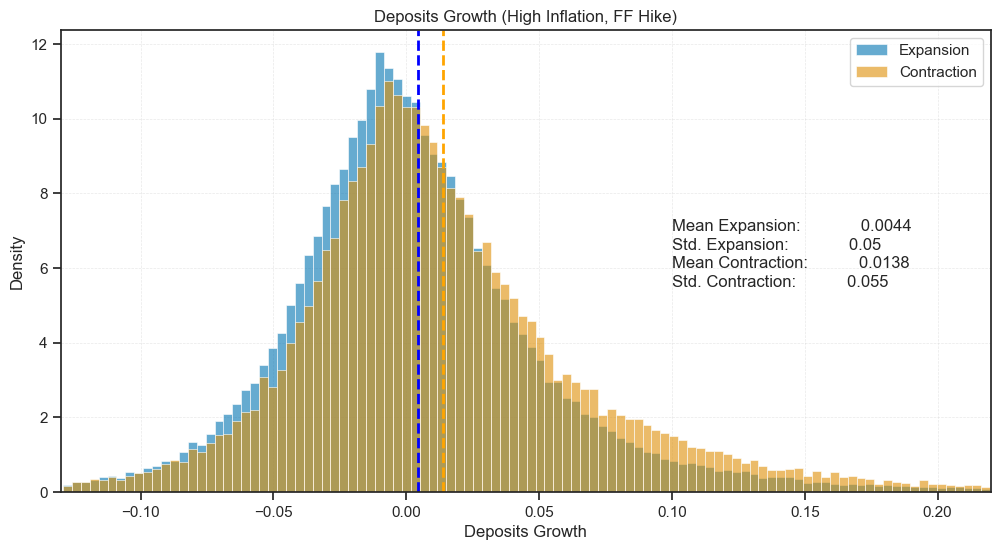

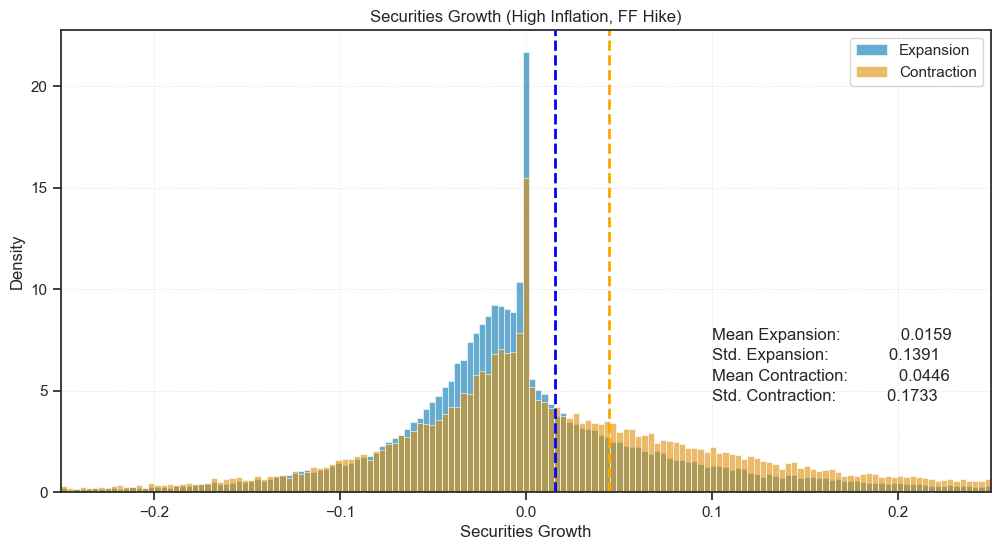

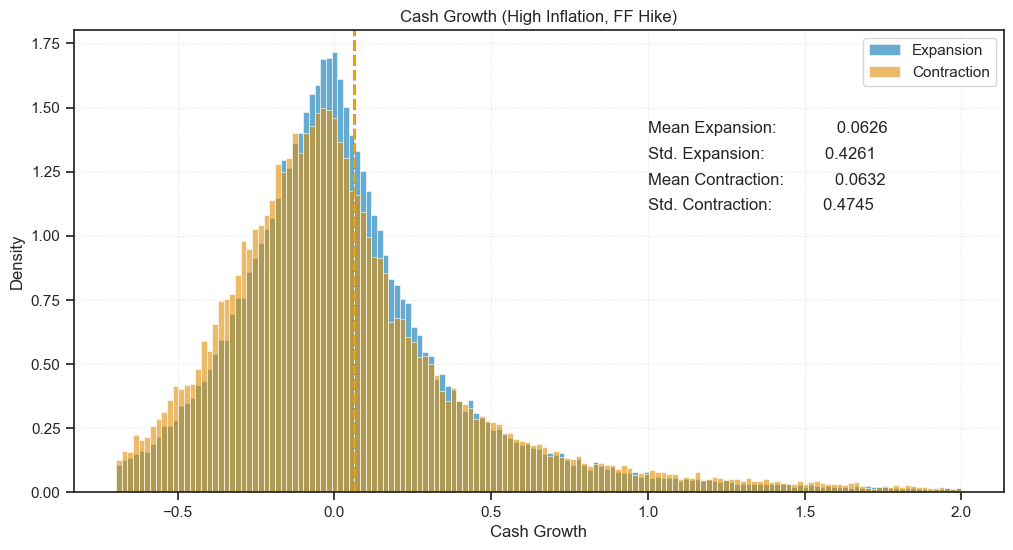

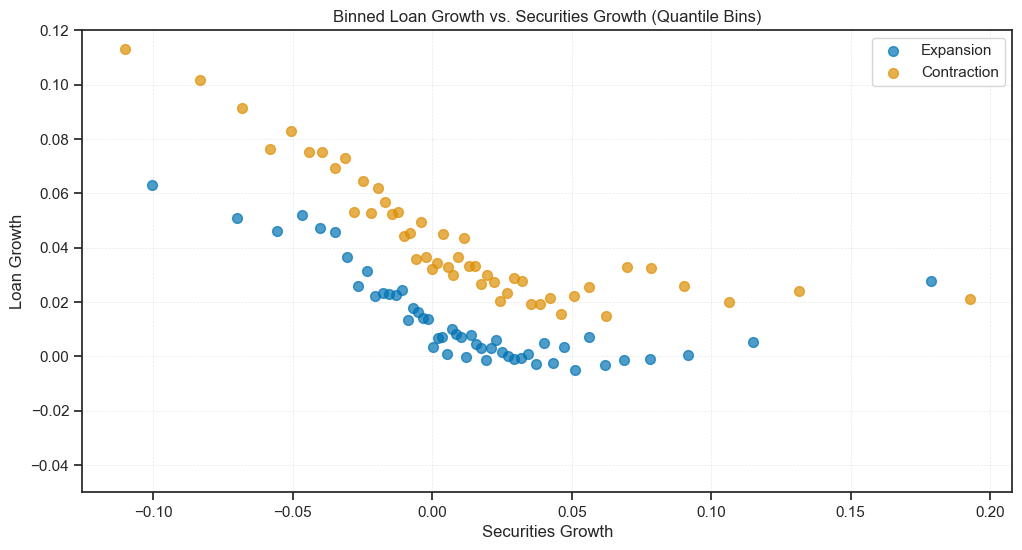

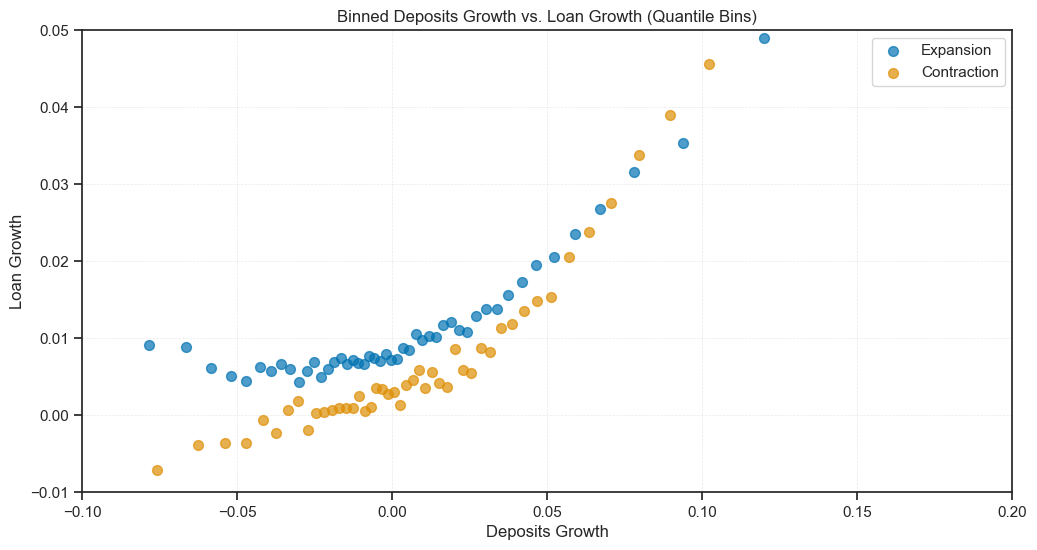

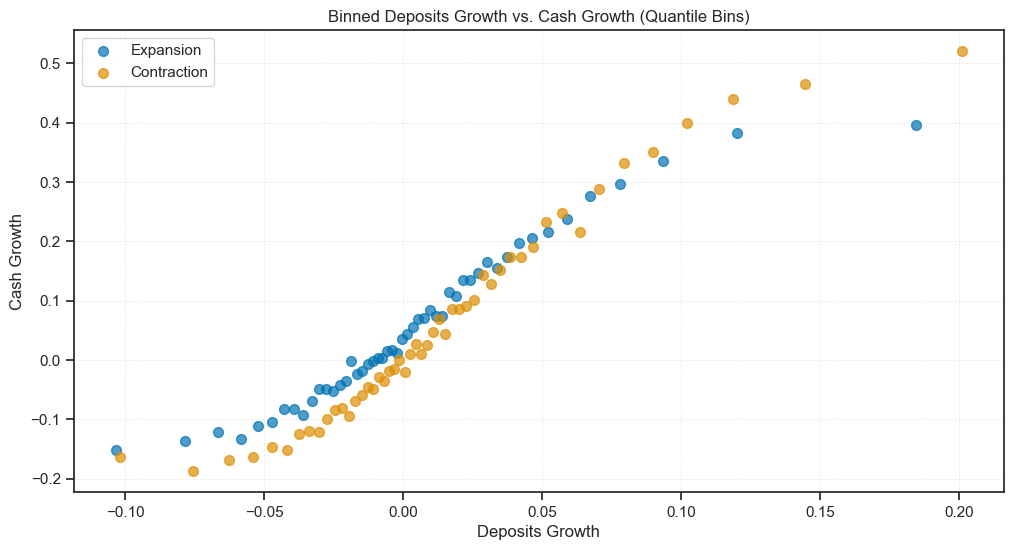

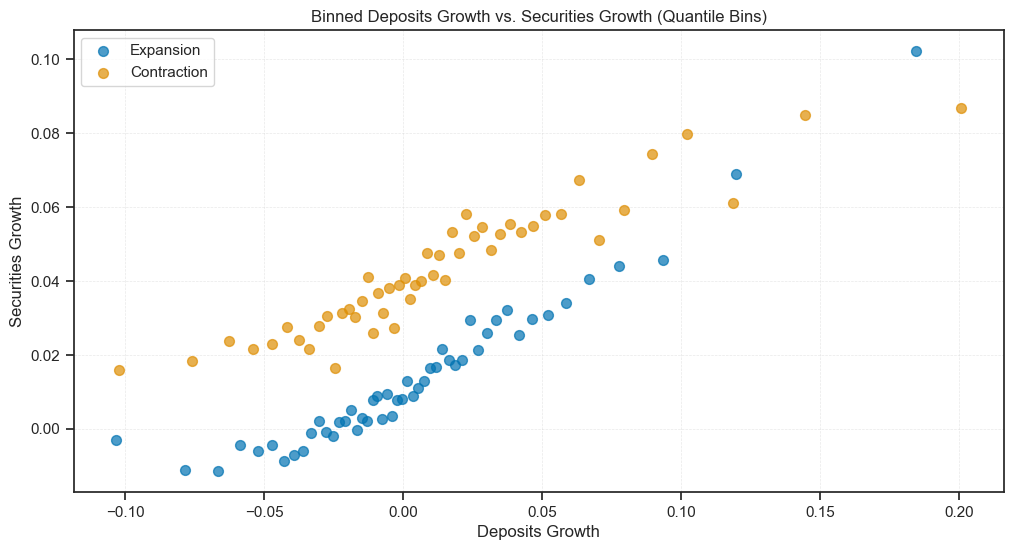

In [69]:
cross_sectional_plots(df, 'ff_hike', num_quantiles=50)

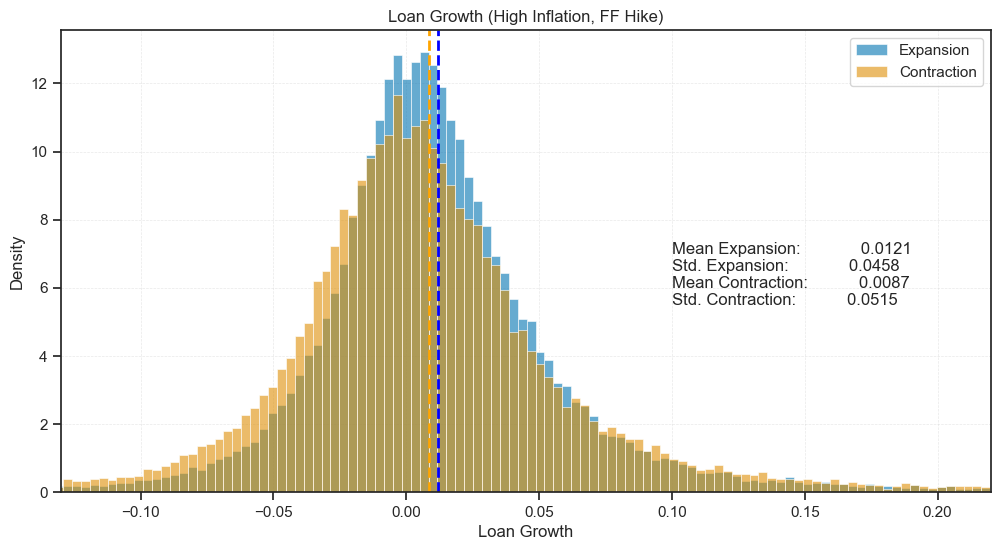

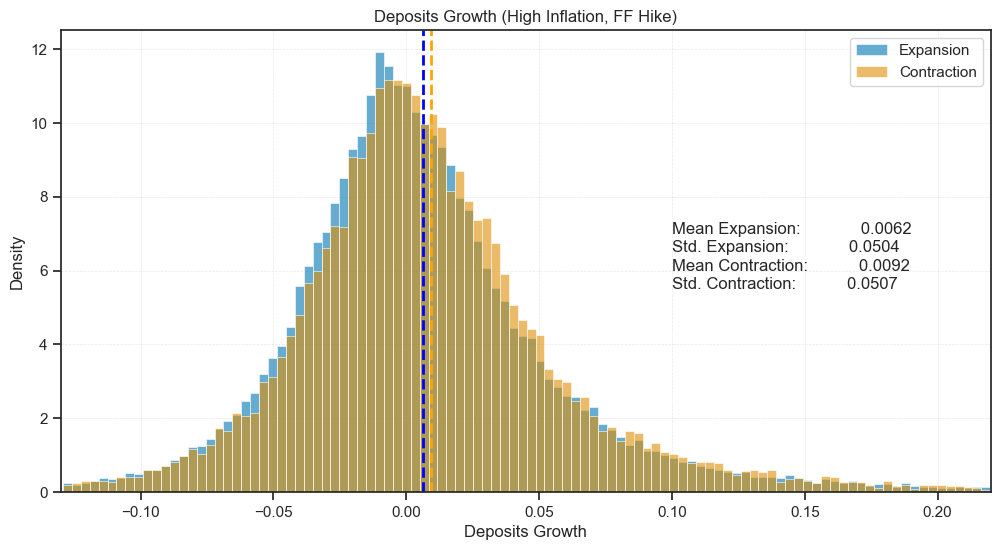

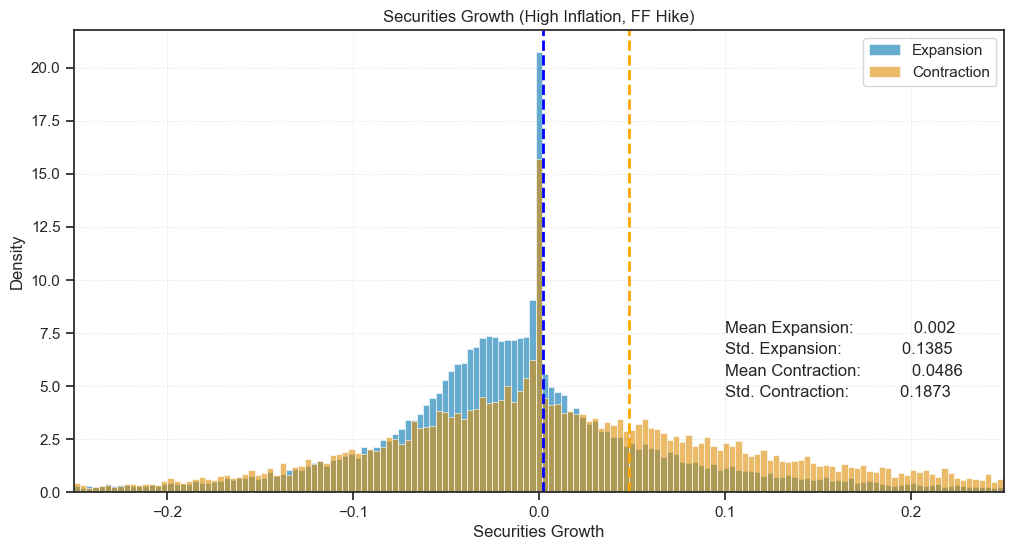

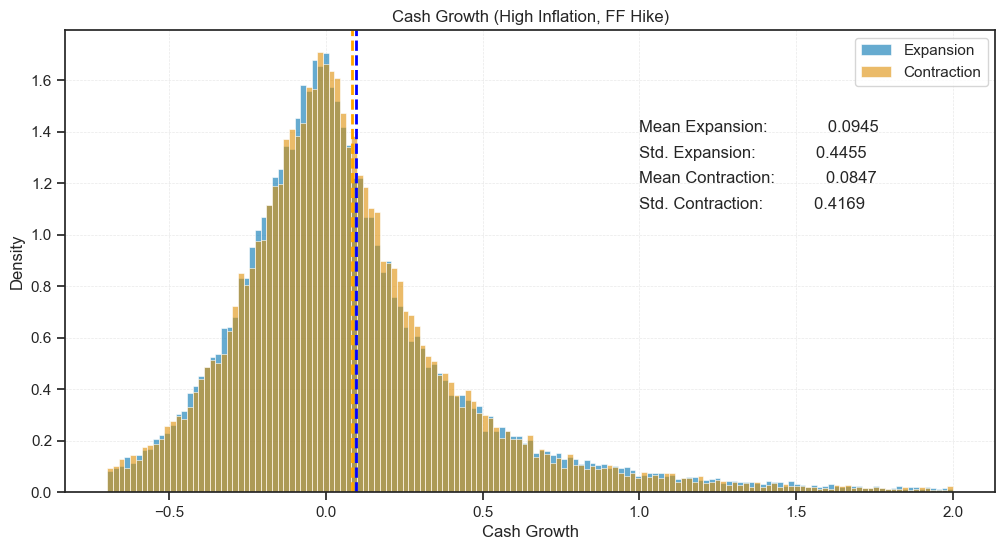

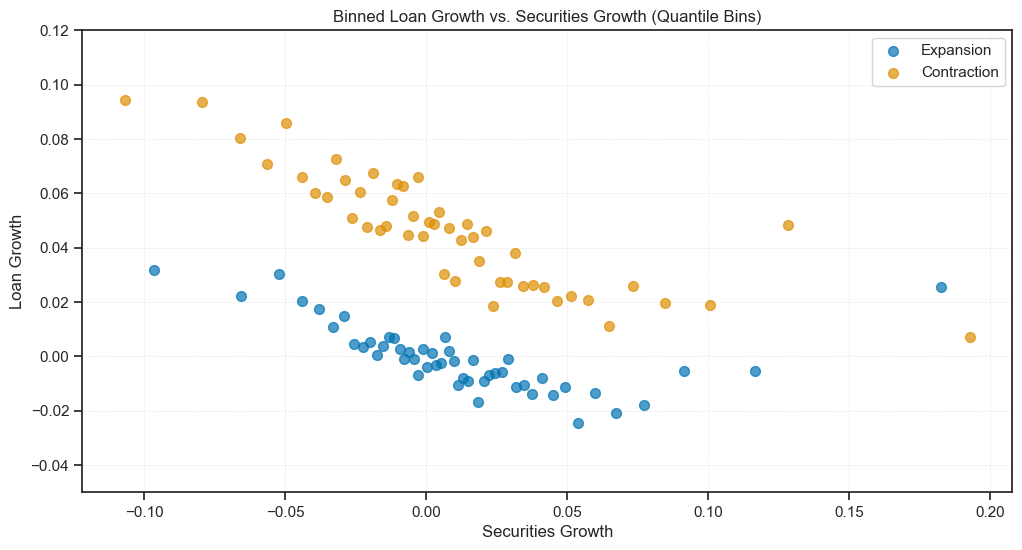

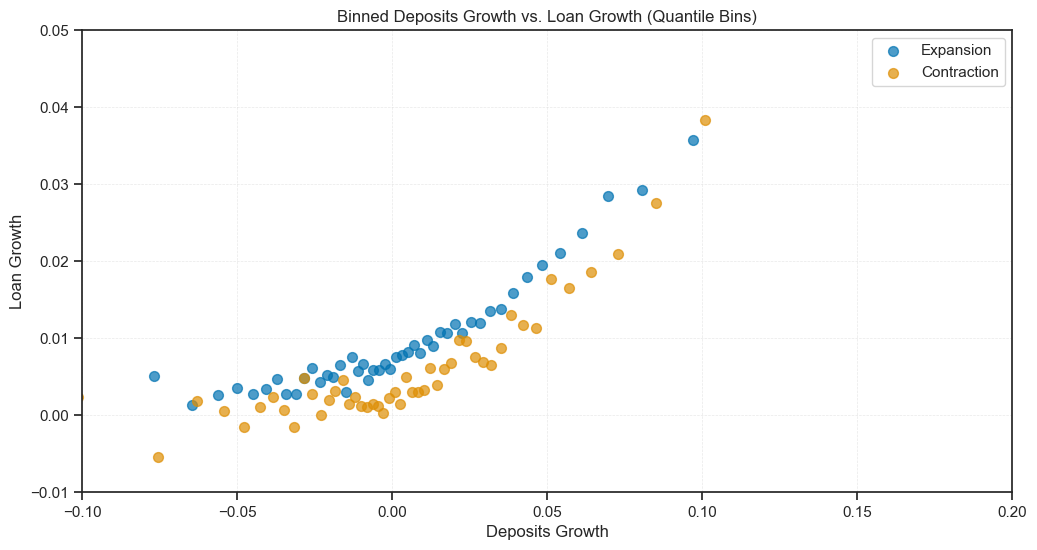

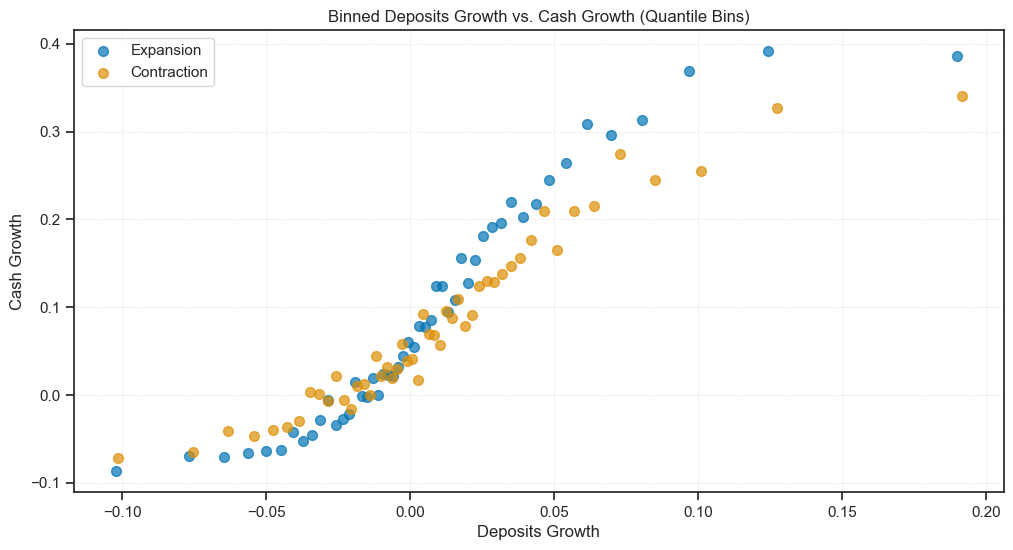

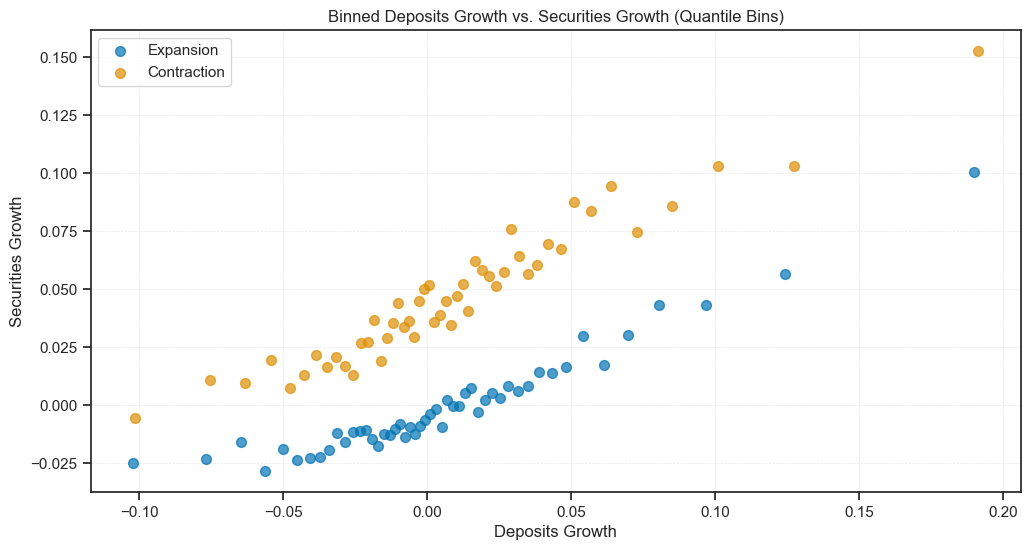

In [71]:
cross_sectional_plots(df, 'mp_shock', num_quantiles=50)